# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from PIL import Image

from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

from tensorflow.keras import utils, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomTranslation, RandomZoom
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetV2B1, EfficientNetV2L

from google.colab import drive

In [2]:
drive.mount('/gdrive/')

Mounted at /gdrive/


# EDA & Data Munging

#### Checking out one image in the dataset...

In [6]:
capstone_data_path = '/gdrive/MyDrive/School-GA_DSI/CapstoneData'

JPEG
(260, 195)
RGB


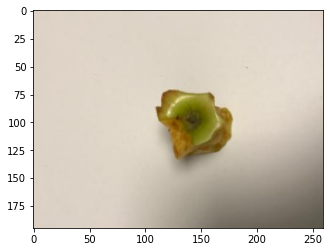

In [7]:
img1 = Image.open(capstone_data_path + '/train/compost/compost1.jpg')

print(img1.format)
print(img1.size)
print(img1.mode)
plt.imshow(img1);

# CITATION: Referenced a Plural Sight article written by Gaurav Singhal
# to better understand some uses of the PIL library:
# https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

In [8]:
img_array1 = np.array(img1)
img_array1.shape

(195, 260, 3)

#### Pulling train and test data into the workbook...  
Note: Train & test images were split randomly into separate train & test folders manually

In [10]:
# list of classes
classes = ['compost', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# dict of classes w. labels
class_dict = {
    'compost': 0,
    'cardboard': 1,  
    'glass': 2, 
    'metal': 3, 
    'paper': 4, 
    'plastic': 5, 
    'trash': 6,
    }

In [11]:
# pulling in train dataset
images_train = []
image_labels_train = []
for c, l in class_dict.items():   # c for class, l for label
    for file in os.listdir(os.path.join(capstone_data_path + '/train', c)):
        file_path = os.path.join(capstone_data_path + '/train', c, file)
        image_train = np.array(Image.open(file_path))
        image_labels_train.append(l)
        images_train.append(image_train)

In [12]:
# convert X_train & y_train to arrays
X_train = np.array(images_train)
print(X_train.shape)

y_train = np.array(image_labels_train)
print(y_train.shape)

(1895, 195, 260, 3)
(1895,)


In [13]:
# Double-check datatype X_train & y_train
type(X_train[0]), type(y_train[0])

(numpy.ndarray, numpy.int64)

In [18]:
# Counts of the classes in the train set
pd.DataFrame(y_train).value_counts()

# Note that the data set is fairly balanced

0    273
6    272
1    270
2    270
3    270
4    270
5    270
dtype: int64

In [19]:
# pulling in test dataset
images_test = []
image_labels_test = []
for c, l in class_dict.items():   # c for class, l for label
    for file in os.listdir(os.path.join(capstone_data_path + '/test', c)):
        file_path = os.path.join(capstone_data_path + '/test', c, file)
        image_test = np.array(Image.open(file_path))
        image_labels_test.append(l)
        images_test.append(image_test)

In [20]:
# convert X_test & y_test to arrays
X_test = np.array(images_test)
print(X_test.shape)
y_test = np.array(image_labels_test)
print(y_test.shape)

(315, 195, 260, 3)
(315,)


In [21]:
# Counts of the classes in the test set
pd.DataFrame(y_test).value_counts()

# Note that the data set is balanced

0    45
1    45
2    45
3    45
4    45
5    45
6    45
dtype: int64

#### Reshape...

In [22]:
y_train_encoded = utils.to_categorical(y_train, num_classes=7)

In [23]:
y_train_encoded.shape

(1895, 7)

In [24]:
y_test_encoded = utils.to_categorical(y_test, num_classes=7)

In [25]:
y_test_encoded.shape

(315, 7)

#### Checking out 1 image from the train set...

[0. 0. 1. 0. 0. 0. 0.]


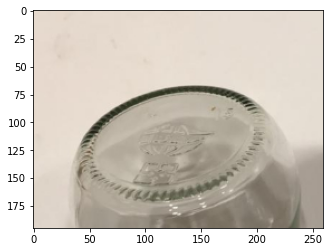

In [26]:
print(y_train_encoded[777]), plt.imshow(X_train[777]);    # label 2 is glass

#### Reduce dtype size of image data, then scale...

In [27]:
# reduce dtype size, then scale...
X_train_scaled = X_train.astype('float32') / 255
X_train_scaled[0][0][0]

array([0.99607843, 0.99607843, 0.99607843], dtype=float32)

In [28]:
X_train_scaled.shape

(1895, 195, 260, 3)

In [29]:
X_test_scaled = X_test.astype('float32') / 255

# Modeling

Baseline Model...

In [30]:
dc = DummyClassifier(random_state=303)
dc.fit(X_train_scaled, y_train_encoded)

DummyClassifier(random_state=303)

In [37]:
# Function for extracting Accuracy score on test set and Confustion Matrix of test set

def model_performance(Xtest, ytest, model):
  # create prediction variable
  y_preds = model.predict(Xtest)
  y_preds_rounded = y_preds.round(0)
  y_preds_arg = np.argmax(y_preds_rounded, axis=1)

  # confusion matrix
  fig, ax = plt.subplots(figsize=(6, 6))
  cmd = ConfusionMatrixDisplay.from_predictions(
      y_true = ytest, 
      y_pred = y_preds_arg,
      display_labels = ['compost', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'],
      xticks_rotation = 'vertical',
      normalize = 'true',
      cmap = 'Blues',
      ax = ax
      )
  cmd.ax_.set_title(type(model))

  print(f'Accuracy score of {model}: ', accuracy_score(ytest, y_preds_arg))
  print(cmd)

Accuracy score of DummyClassifier(random_state=303):  0.14285714285714285


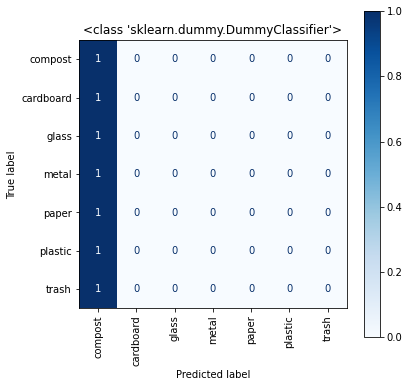

In [38]:
model_performance(X_test_scaled, y_test, dc);

  #### Simple Feed Forward Model...

In [39]:
# figuring out batch size vs. steps per epoch
X_train_scaled.shape[0]*.8/256

5.921875

In [40]:
ffm = Sequential()
ffm.add(Flatten())
ffm.add(Dense(128, activation = 'relu'))
ffm.add(Dense(7, activation = 'softmax'))

ffm.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam', 
    metrics = ['accuracy']
    )

hist_ffm = ffm.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs = 90,        # num times the model will work through the full data set
    batch_size = 256,   # num. observations to process before updating internal model
    validation_split = .2,
    shuffle = True,
    steps_per_epoch = 6,
    callbacks = EarlyStopping(patience=15, restore_best_weights=True))

# CITATION: found a way to shuffle the training set
# using the top post from user sdcbr on Stack Overflow:
# https://stackoverflow.com/questions/51623191/keras-is-there-an-easy-way-to-mutate-shuffle-data-in-out-of-the-training-set

Epoch 1/90
6/6 [==============================] - 4s 166ms/step - loss: 214.7124 - accuracy: 0.1741 - val_loss: 417.6380 - val_accuracy: 0.0000e+00
Epoch 2/90
6/6 [==============================] - 0s 78ms/step - loss: 143.3309 - accuracy: 0.1860 - val_loss: 201.2225 - val_accuracy: 0.0000e+00
Epoch 3/90
6/6 [==============================] - 0s 76ms/step - loss: 49.8851 - accuracy: 0.1755 - val_loss: 129.7349 - val_accuracy: 0.0000e+00
Epoch 4/90
6/6 [==============================] - 0s 73ms/step - loss: 20.4651 - accuracy: 0.2117 - val_loss: 62.4450 - val_accuracy: 0.0000e+00
Epoch 5/90
6/6 [==============================] - 0s 73ms/step - loss: 8.4660 - accuracy: 0.2065 - val_loss: 41.2680 - val_accuracy: 0.0000e+00
Epoch 6/90
6/6 [==============================] - 0s 72ms/step - loss: 5.9907 - accuracy: 0.2098 - val_loss: 13.1464 - val_accuracy: 0.0000e+00
Epoch 7/90
6/6 [==============================] - 0s 74ms/step - loss: 3.1089 - accuracy: 0.1972 - val_loss: 2.5710 - val_accu

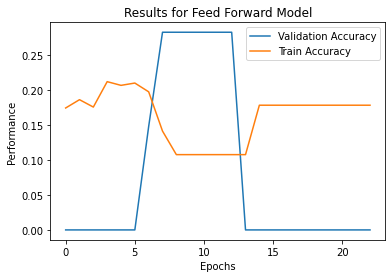

In [50]:
plt.plot(hist_ffm.history['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_ffm.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Results for Feed Forward Model');

Accuracy score of <keras.engine.sequential.Sequential object at 0x7f6f11447150>:  0.14285714285714285


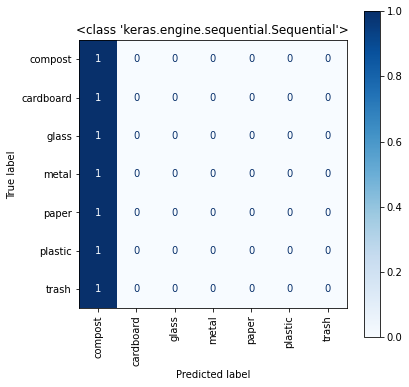

In [47]:
model_performance(X_test_scaled, y_test, ffm)

In [55]:
# saved my best ffm model and imported below with associated confusion matrix
# ffm.save('ffm_34acc.h5')

In [ ]:
best_ffm = load_model('/gdrive/MyDrive/School-GA_DSI/CapstoneData/models/ffm_34acc.h5')

Accuracy score of <keras.engine.sequential.Sequential object at 0x7f6e082047d0>:  0.3396825396825397


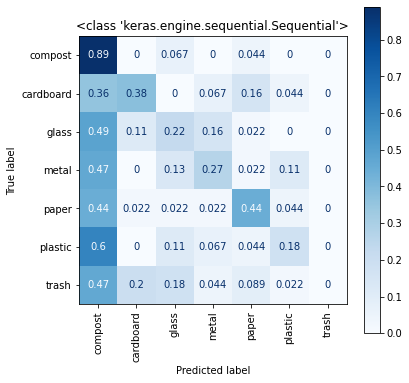

In [ ]:
model_performance(X_test_scaled, y_test, best_ffm)

#### CNN Model w. Augmentation Layers

In [48]:
cnn = Sequential()

# augmentation
cnn.add(RandomContrast(.2, seed=123))
cnn.add(RandomFlip(mode='horizontal_and_vertical', seed=123))
cnn.add(RandomTranslation(.15, .15, fill_mode='nearest', seed=123))
cnn.add(RandomZoom(.1, fill_mode='nearest', seed=123))

# convolutional layers
cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))    # start small
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))    # add more filters
cnn.add(MaxPooling2D())
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D())

# dense layers
cnn.add(Flatten())      # required b/c Dense layers expect a flattened array
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(64, activation = 'relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(32, activation = 'relu'))
cnn.add(Dropout(.5))
cnn.add(Dense(7, activation = 'softmax'))

cnn.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(.001), 
    metrics = ['accuracy']
    )

hist_cnn = cnn.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs = 50,        # num times the model will work through the full data set
    batch_size = 256,   # num. observations to process before updating internal model
    validation_split = .2,
    shuffle = True,
    steps_per_epoch = 6,
    callbacks = EarlyStopping(patience=20, restore_best_weights=True))

# CITATION: Received assistance from my TA, Noah Christiansen with playing around with
# batch size vs. steps per epoch, using the Adam class for optimizer, and using
# restore best weights in callbacks

Epoch 1/50
6/6 [==============================] - 12s 418ms/step - loss: 1.9885 - accuracy: 0.1570 - val_loss: 2.0229 - val_accuracy: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 1s 178ms/step - loss: 1.9276 - accuracy: 0.1741 - val_loss: 2.0901 - val_accuracy: 0.0000e+00
Epoch 3/50
6/6 [==============================] - 1s 178ms/step - loss: 1.9163 - accuracy: 0.1827 - val_loss: 2.1997 - val_accuracy: 0.0000e+00
Epoch 4/50
6/6 [==============================] - 1s 182ms/step - loss: 1.9056 - accuracy: 0.1715 - val_loss: 2.2659 - val_accuracy: 0.0000e+00
Epoch 5/50
6/6 [==============================] - 1s 174ms/step - loss: 1.8654 - accuracy: 0.2051 - val_loss: 2.3102 - val_accuracy: 0.0000e+00
Epoch 6/50
6/6 [==============================] - 1s 177ms/step - loss: 1.8537 - accuracy: 0.2197 - val_loss: 2.3076 - val_accuracy: 0.0000e+00
Epoch 7/50
6/6 [==============================] - 1s 174ms/step - loss: 1.8125 - accuracy: 0.2388 - val_loss: 2.4365 - val_accuracy: 0.

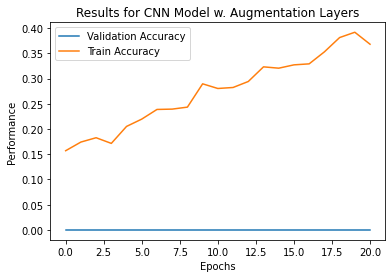

In [51]:
plt.plot(hist_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_cnn.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Results for CNN Model w. Augmentation Layers');

Accuracy score of <keras.engine.sequential.Sequential object at 0x7f6e0817ec10>:  0.14285714285714285


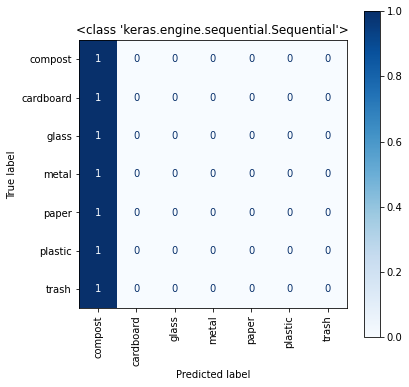

In [52]:
model_performance(X_test_scaled, y_test, cnn)

#### Model Pre-trained with EfficientNetV2B1

In [53]:
# save data augmentation as a variable to use below...
data_augmentation = Sequential([
    RandomContrast(.2, seed=123),
    RandomFlip(mode='horizontal_and_vertical', seed=123),
    RandomTranslation(.15, .15, fill_mode='nearest', seed=123),
    RandomZoom(.05, fill_mode='nearest', seed=123)
    ])

In [54]:
# pre-trained model - EfficientNetV2B1
base_model = EfficientNetV2B1(
    include_top=False,    # False excludes the output/top layer from the pre-trained model
    weights="imagenet",   # these are the pre-trained weights
    input_shape=(195, 260, 3)
)

# freeze the first layer (layer above) for training
base_model.trainable = False

# layers
inputs = Input(shape=(195, 260, 3))

### augmentation layers
da = data_augmentation(inputs)

### pre-trained model layers
x = base_model(da, training=False)

### convolutional layers
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D()(x)

### dense layers
x = Flatten()(x)                    # Dense layers expect a flattened array
x = Dense(128, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(.2)(x)
outputs = Dense(7, activation='softmax')(x)
ptm1 = Model(inputs, outputs)

# train the model
ptm1.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(.001), 
    metrics = ['accuracy']
    )

hist_ptm1 = ptm1.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs=20,        # num times the model will work through the full data set
    batch_size=256,    # num. observations to process before updating internal model
    steps_per_epoch=6,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(patience=15, restore_best_weights=True)
    )

28467200/28456008 [==============================] - 1s 0us/step
Epoch 1/20
6/6 [==============================] - 17s 1s/step - loss: 1.9611 - accuracy: 0.1748 - val_loss: 2.7317 - val_accuracy: 0.0000e+00
Epoch 2/20
6/6 [==============================] - 2s 414ms/step - loss: 1.8766 - accuracy: 0.1755 - val_loss: 2.6875 - val_accuracy: 0.0000e+00
Epoch 3/20
6/6 [==============================] - 2s 390ms/step - loss: 1.8673 - accuracy: 0.1649 - val_loss: 3.0565 - val_accuracy: 0.0000e+00
Epoch 4/20
6/6 [==============================] - 2s 385ms/step - loss: 1.8453 - accuracy: 0.1768 - val_loss: 2.8219 - val_accuracy: 0.0000e+00
Epoch 5/20
6/6 [==============================] - 2s 390ms/step - loss: 1.8382 - accuracy: 0.1755 - val_loss: 3.0508 - val_accuracy: 0.0000e+00
Epoch 6/20
6/6 [==============================] - 2s 388ms/step - loss: 1.8283 - accuracy: 0.1748 - val_loss: 3.4338 - val_accuracy: 0.0000e+00
Epoch 7/20
6/6 [==============================] - 2s 386ms/step - loss: 1

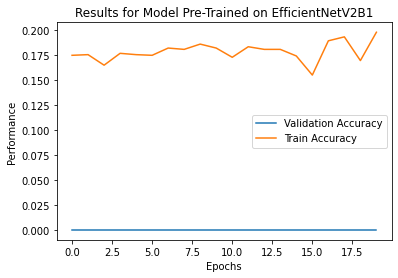

In [55]:
plt.plot(hist_ptm1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_ptm1.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Results for Model Pre-Trained on EfficientNetV2B1');

Accuracy score of <keras.engine.functional.Functional object at 0x7f6deef04f50>:  0.14285714285714285


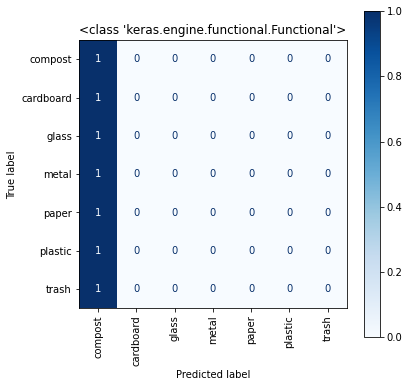

In [56]:
model_performance(X_test_scaled, y_test, ptm1)

#### Model Pre-trained with EfficientNetV2B1 and Fine-Tuned

In [57]:
# check number of layers in pre-trained model
len(base_model.layers)

313

In [58]:
### Fine-tuning

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:280]:
    layer.trainable = False

ptm1.compile(
    optimizer=Adam(.00001),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

hist_ptm1ft = ptm1.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs=10,        # num times the model will work through the full data set
    batch_size=128,    # num. observations to process before updating internal model
    steps_per_epoch=12,
    validation_split=.2)

Epoch 1/10
12/12 [==============================] - 17s 501ms/step - loss: 1.8071 - accuracy: 0.1821 - val_loss: 3.7949 - val_accuracy: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 3s 222ms/step - loss: 1.8146 - accuracy: 0.1656 - val_loss: 3.6374 - val_accuracy: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 3s 224ms/step - loss: 1.8076 - accuracy: 0.1689 - val_loss: 3.7171 - val_accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 3s 223ms/step - loss: 1.8046 - accuracy: 0.1939 - val_loss: 3.8452 - val_accuracy: 0.0000e+00
Epoch 5/10
12/12 [==============================] - 3s 225ms/step - loss: 1.8115 - accuracy: 0.1642 - val_loss: 3.7711 - val_accuracy: 0.0000e+00
Epoch 6/10
12/12 [==============================] - 3s 223ms/step - loss: 1.8047 - accuracy: 0.1860 - val_loss: 3.7314 - val_accuracy: 0.0000e+00
Epoch 7/10
12/12 [==============================] - 3s 225ms/step - loss: 1.8026 - accuracy: 0.1821 - val_loss: 3.7853 - va

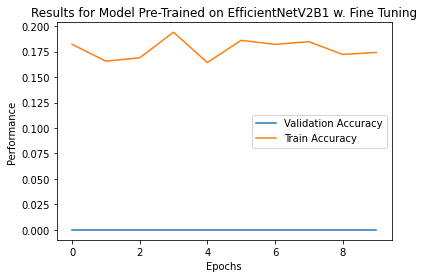

In [59]:
plt.plot(hist_ptm1ft.history['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_ptm1ft.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Results for Model Pre-Trained on EfficientNetV2B1 w. Fine Tuning');

Accuracy score of <keras.engine.functional.Functional object at 0x7f6deef04f50>:  0.14285714285714285


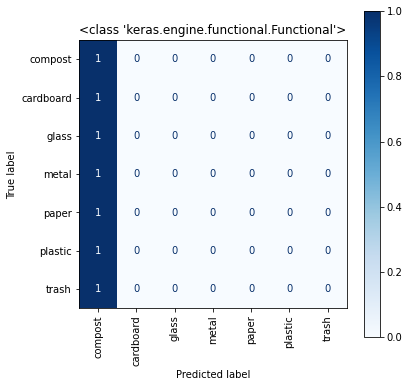

In [60]:
model_performance(X_test_scaled, y_test, ptm1)

#### Model Pre-trained with EfficientNetV2L

In [61]:
# pre-trained model - EfficientNetV2L
base_model2 = EfficientNetV2L(
    include_top=False,    # False excludes the output/top layer from the pre-trained model
    weights="imagenet",   # these are the pre-trained weights
    input_shape=(195, 260, 3)
    )

# freeze the first layer (layer above) for training
base_model2.trainable=False

# layers
inputs = Input(shape=(195, 260, 3))

### augmentation layers
da = data_augmentation(inputs)

### pre-trained model layers
x = base_model2(da, training=False)

### convolutional layers
x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D()(x)

### dense layers
x = Flatten()(x)                    # Dense layers expect a flattened array
x = Dense(128, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(.2)(x)
outputs = Dense(7, activation='softmax')(x)
ptm2 = Model(inputs, outputs)

# train the model
ptm2.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(.00095), 
    metrics = ['accuracy']
    )

hist_ptm2 = ptm2.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs=10,        # num times the model will work through the full data set
    batch_size=128,   # num. observations to process before updating internal model
    validation_split=.2,
    shuffle=True,
    steps_per_epoch=12
    )

473186304/473176280 [==============================] - 15s 0us/step
Epoch 1/10
12/12 [==============================] - 53s 2s/step - loss: 1.9749 - accuracy: 0.1656 - val_loss: 2.5970 - val_accuracy: 0.0000e+00
Epoch 2/10
12/12 [==============================] - 13s 1s/step - loss: 1.8473 - accuracy: 0.1913 - val_loss: 2.9131 - val_accuracy: 0.0000e+00
Epoch 3/10
12/12 [==============================] - 13s 1s/step - loss: 1.8170 - accuracy: 0.2137 - val_loss: 3.4876 - val_accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - 13s 1s/step - loss: 1.7971 - accuracy: 0.2269 - val_loss: 3.1330 - val_accuracy: 0.0000e+00
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 1.8249 - accuracy: 0.2210 - val_loss: 3.3222 - val_accuracy: 0.0053
Epoch 6/10
12/12 [==============================] - 13s 1s/step - loss: 1.7907 - accuracy: 0.2216 - val_loss: 3.2728 - val_accuracy: 0.0000e+00
Epoch 7/10
12/12 [==============================] - 13s 1s/step - loss: 

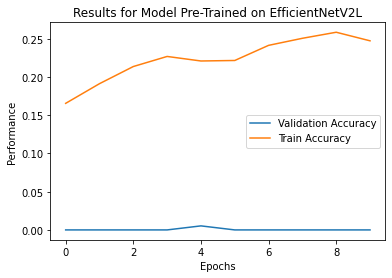

In [62]:
plt.plot(hist_ptm2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_ptm2.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Results for Model Pre-Trained on EfficientNetV2L');

Accuracy score of <keras.engine.functional.Functional object at 0x7f6b70529b50>:  0.1523809523809524


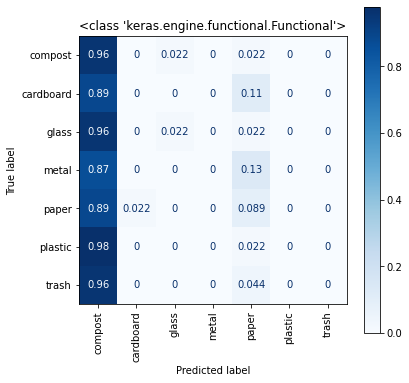

In [63]:
model_performance(X_test_scaled, y_test, ptm2)

In [133]:
# saved my best pre-trained model and imported below with associated confusion matrix
# ptm2.save('ptm2_17acc.h5')

In [64]:
best_ptm = load_model('/gdrive/MyDrive/School-GA_DSI/CapstoneData/models/ptm2_17acc.h5')

Accuracy score of <keras.engine.functional.Functional object at 0x7f6b6f539dd0>:  0.17142857142857143


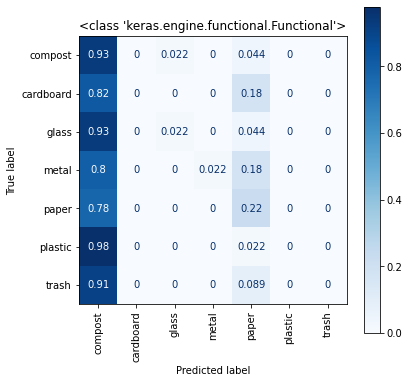

In [65]:
model_performance(X_test_scaled, y_test, best_ptm)

Fine-Tuning the EfficientNetV2L pre-trained model

In [66]:
# checking the number of layers in the base model
len(base_model2.layers)

956

In [67]:
# figuring out batch size vs. steps per epoch
X_train_scaled.shape[0]*.8/8

189.5

In [68]:
### Fine-tuning on EfficientNetV2L

# Freeze early layers
base_model2.trainable=True
for layer in base_model.layers[:900]:
    layer.trainable=False

ptm2.compile(
    optimizer=Adam(.00001),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

hist_ptm2ft = ptm2.fit(
    X_train_scaled, 
    y_train_encoded, 
    epochs=15,        # num times the model will work through the full data set
    batch_size=8,    # num. observations to process before updating internal model
    steps_per_epoch=190,
    validation_split=.2,
    shuffle=True
    )

Epoch 1/15
190/190 [==============================] - 131s 423ms/step - loss: 1.8306 - accuracy: 0.1794 - val_loss: 3.7722 - val_accuracy: 0.0000e+00
Epoch 2/15
190/190 [==============================] - 71s 375ms/step - loss: 1.8092 - accuracy: 0.1913 - val_loss: 3.0355 - val_accuracy: 0.0000e+00
Epoch 3/15
190/190 [==============================] - 71s 375ms/step - loss: 1.7782 - accuracy: 0.2408 - val_loss: 3.5431 - val_accuracy: 0.0000e+00
Epoch 4/15
190/190 [==============================] - 71s 375ms/step - loss: 1.7720 - accuracy: 0.2328 - val_loss: 3.7502 - val_accuracy: 0.0000e+00
Epoch 5/15
190/190 [==============================] - 71s 375ms/step - loss: 1.7155 - accuracy: 0.2685 - val_loss: 5.0807 - val_accuracy: 0.0000e+00
Epoch 6/15
190/190 [==============================] - 71s 375ms/step - loss: 1.6126 - accuracy: 0.3186 - val_loss: 7.5386 - val_accuracy: 0.0000e+00
Epoch 7/15
190/190 [==============================] - 71s 375ms/step - loss: 1.5318 - accuracy: 0.3720 - 

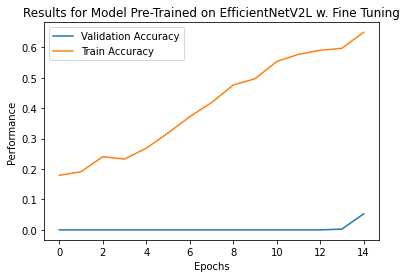

In [69]:
plt.plot(hist_ptm2ft.history['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_ptm2ft.history['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.title('Results for Model Pre-Trained on EfficientNetV2L w. Fine Tuning');

Accuracy score of <keras.engine.functional.Functional object at 0x7f6b70529b50>:  0.3968253968253968


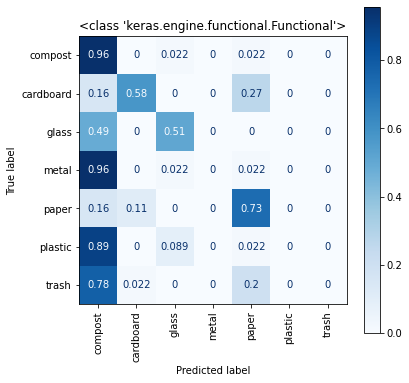

In [70]:
model_performance(X_test_scaled, y_test, ptm2)

In [ ]:
# saved my best pre-trained model w. fine tuning and imported below with associated confusion matrix
# ptm2.save('ptm2ft_67acc2.h5')

In [71]:
best_ft_model = load_model('/gdrive/MyDrive/School-GA_DSI/CapstoneData/models/ptm2ft_67acc.h5')

Accuracy score of <keras.engine.functional.Functional object at 0x7f6b5cac8e50>:  0.6698412698412698


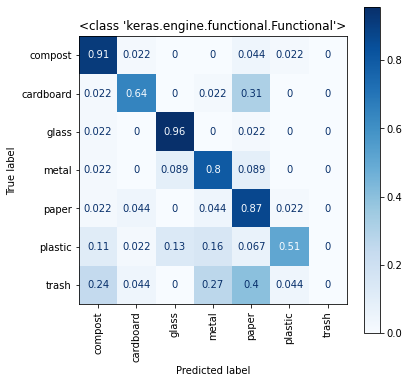

In [72]:
model_performance(X_test_scaled, y_test, best_ft_model)

Check to see if the probablity of trash being predicted was greater than 0 for any observation in the test set...

In [78]:
y_preds_best = best_ft_model.predict(X_test_scaled).round(2)

In [108]:
trash_probs = []
for observation in y_preds_best:
    trash = float(observation[-1])
    trash_probs.append(float(trash))

print(pd.DataFrame(np.array(trash_probs)).value_counts())

# Trash was predicted at 0% for all 315 test images :(

0.0    315
dtype: int64
